## 📖 Background
You work for an international HR consultancy helping companies attract and retain top talent in the competitive tech industry. As part of your services, you provide clients with insights into industry salary trends to ensure they remain competitive in hiring and compensation practices.

Your team wants to use a data-driven approach to analyse how various factors—such as job role, experience level, remote work, and company size—impact salaries globally. By understanding these trends, you can advise clients on offering competitive packages to attract the best talent.

In this competition, you’ll explore and visualise salary data from thousands of employees worldwide. f you're tackling the advanced level, you'll go a step further—building predictive models to uncover key salary drivers and providing insights on how to enhance future data collection.

## 💪 Competition challenge 3

In this final level, you’ll develop predictive models and dive deeper into the dataset. If this feels overwhelming, consider completing the earlier levels first!
Create a report that answers the following:
- Analyse how factors such as country, experience level, and remote ratio impact salaries for Data Analysts, Data Scientists, and Machine Learning Engineers. In which conditions do professionals achieve the highest salaries?
- Develop a predictive model to estimate an employee’s salary (in USD) using experience level, company location, and remote ratio. Which features are the strongest predictors of salary?
- Expand your model by incorporating additional features, such as company size and employment type. Evaluate its performance, what improves, and what doesn’t? Finally, propose new features to make future salary predictions even more accurate future salary predictions even more accurate.

# Loading and Preprocessing Data

In [62]:
import pandas as pd
import warnings
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error

sns.set_style("darkgrid")
warnings.simplefilter(action='ignore', category=FutureWarning)
df = pd.read_csv('salaries.csv')

In [63]:
sorted_experience_level = ['EN', 'MI', 'SE', 'EX']
sorted_company_size = ['S', 'M', 'L']

df['experience_level'] = pd.Categorical(df['experience_level'], categories=sorted_experience_level, ordered=True)
df['company_size'] = pd.Categorical(df['company_size'], categories=sorted_company_size, ordered=True)


In [64]:
df['remote_ratio'] = np.where(df['remote_ratio']==0, 'presential', np.where(df['remote_ratio']==50, 'partial_remote','full_remote'))
df['remote_ratio'] = df['remote_ratio'].astype('category')

In [65]:
cat_cols = ['employment_type', 'salary_currency', 'employee_residence', 'company_location']
for col in cat_cols: 
    df[col] = df[col].astype('category')

# Questions

## Question 1: Analyse how factors such as country, experience level, and remote ratio impact salaries for Data Analysts, Data Scientists, and Machine Learning Engineers. In which conditions do professionals achieve the highest salaries?

### Country

In [66]:
jobs_in_order = [ 'Data Analyst', 'Data Scientist', 'Machine Learning Engineer']  
mini_df = df[df['job_title'].isin(jobs_in_order)]

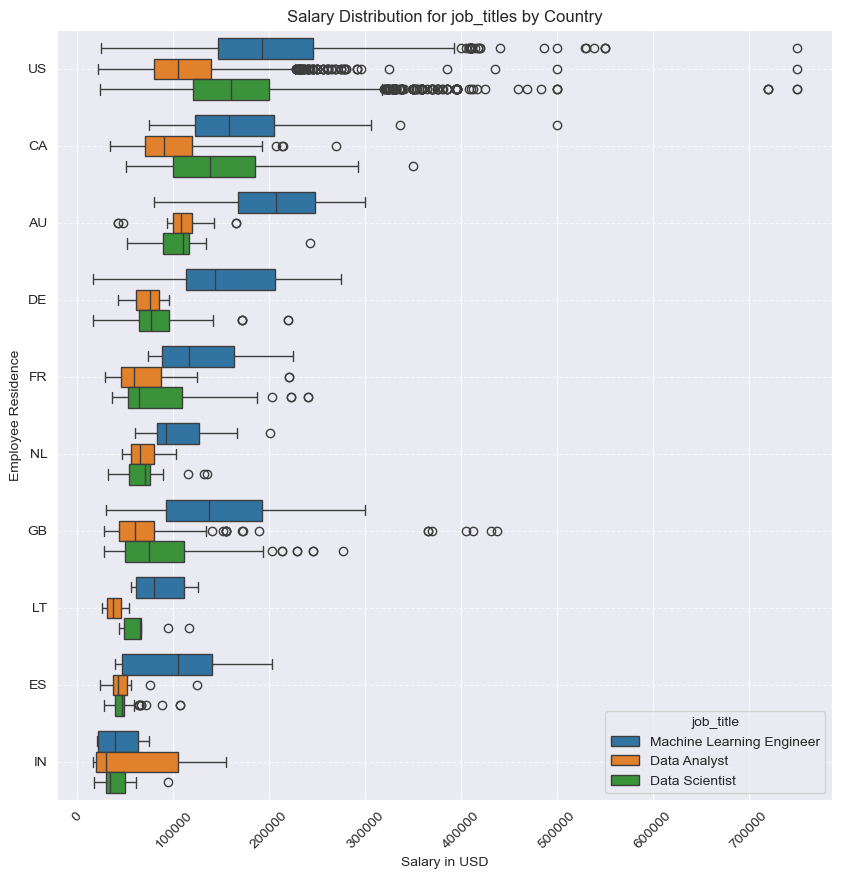

In [67]:
n_countries = 10
plt.figure(figsize=(10, n_countries))

top_countries = mini_df.groupby('employee_residence')['salary_in_usd'].agg('count').nlargest(n_countries).index.to_list()
salary_ordered_countries = mini_df.groupby('employee_residence')['salary_in_usd'].agg('median').sort_values(ascending=False).index.to_list()
salary_ordered_countries = [country for country in salary_ordered_countries if country in top_countries]

countries_df = mini_df[mini_df['employee_residence'].isin(top_countries)] 

sns.boxplot(data=countries_df, y='employee_residence', x='salary_in_usd', hue='job_title', order=salary_ordered_countries)
plt.title(f"Salary Distribution for job_titles by the top 10 frequest Countries")
plt.xlabel("Salary in USD")  
plt.ylabel("Employee Residence")  
plt.grid(axis="y", linestyle="--", alpha=0.7) 
plt.xticks(rotation=45) 

plt.show()

- The distribution of salaries depend on the country and the job title.
- In general, the ranges are wide for the most numerous countries and there is a high presence of outliers, indicating there are other factors that may impact the salary.
- MLE is in general the best paid job title and data analyst the worst.

### Experience Level

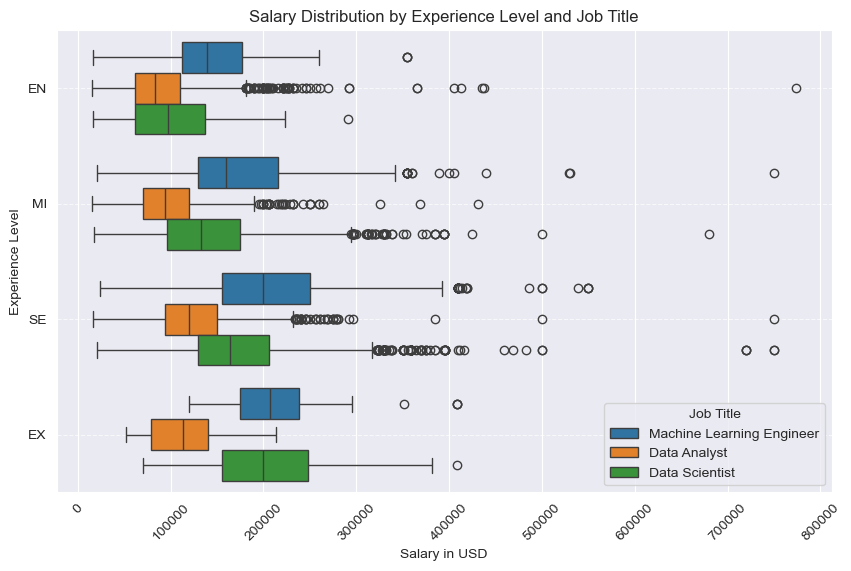

In [71]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=mini_df, y='experience_level', x='salary_in_usd', hue='job_title')

plt.title("Salary Distribution by Experience Level and Job Title")
plt.ylabel("Experience Level")  
plt.xlabel("Salary in USD")  
plt.legend(title="Job Title") 
plt.grid(axis="y", linestyle="--", alpha=0.7) 
plt.xticks(rotation=45) 

plt.show()

- Salaries are different depending on the job title and in general Data Analysts < Data Scientists < Machine Learning Engineers.
- The range for each combination job title - experience level suggests the impact of other factors like country, remote policy or industry.
- Outliers on the high end for the most combinations
- In general the salary grows with experience. There is an exception, though: expert Data Analysts.

### Remote Ratio

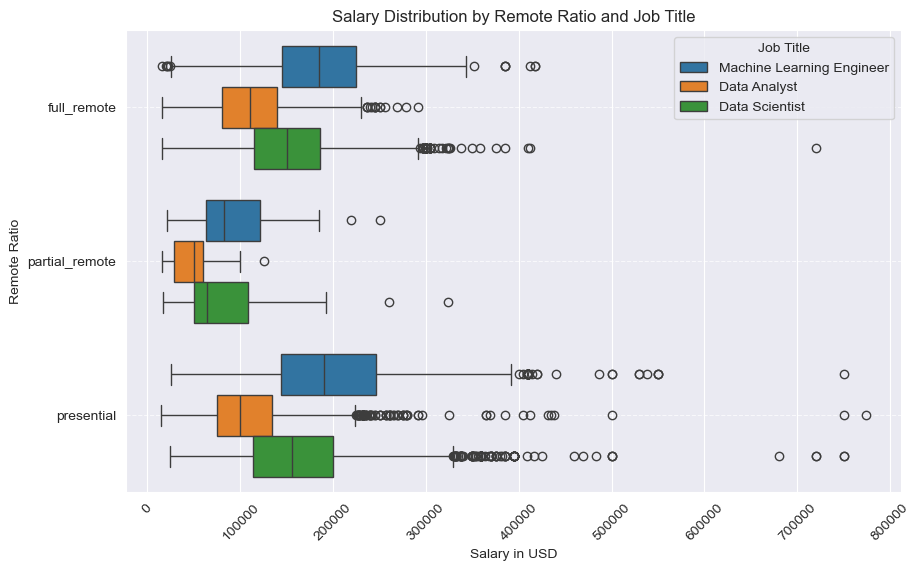

In [73]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=mini_df, y='remote_ratio', x='salary_in_usd', hue='job_title')

plt.title("Salary Distribution by Remote Ratio and Job Title")
plt.ylabel("Remote Ratio")  
plt.xlabel("Salary in USD")  
plt.legend(title="Job Title") 
plt.grid(axis="y", linestyle="--", alpha=0.7) 
plt.xticks(rotation=45) 

plt.show()

- Partial_remote is the less paid kind of contract.
- Presential is the best paid kind of contract for MLE and DS. Full remote is best paid for DA
- The wide ranges and presence of outliers suggest there are other factor that impact the salary.

## Question 2: Develop a predictive model to estimate an employee’s salary (in USD) using experience level, company location, and remote ratio. Which features are the strongest predictors of salary?

Best parameters: {'max_depth': None, 'n_estimators': 100}
Train RMSE (CV Mean): 66144.0176
Test RMSE: 66101.2818


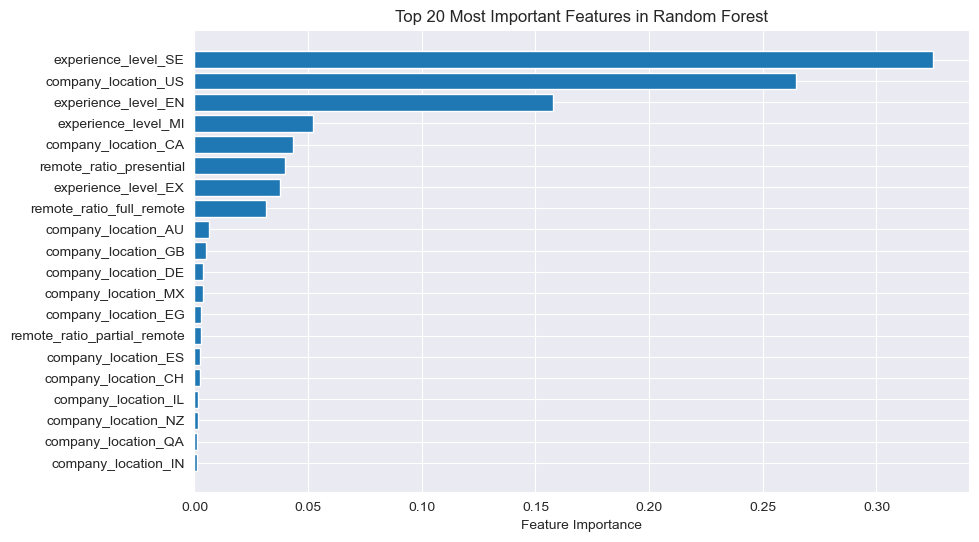

In [78]:
df_dum=pd.get_dummies(df[['salary_in_usd', 'experience_level', 'company_location', 'remote_ratio']])

# Features and target
y = df_dum['salary_in_usd'] 
X = df_dum.drop('salary_in_usd', axis=1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# RandomForest with GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None]
}
rf_cv = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, 
                     scoring='neg_root_mean_squared_error', n_jobs=-1)
rf_cv.fit(X_train, y_train)

# Best model
best_rf = rf_cv.best_estimator_
print("Best parameters:", rf_cv.best_params_)

# Train RMSE (CV)
cv_scores = -cross_val_score(best_rf, X_train, y_train, cv=5, 
                             scoring='neg_root_mean_squared_error')
train_rmse = np.mean(cv_scores)

# Test RMSE
y_pred_test = best_rf.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Train RMSE (CV Mean): {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

# Feature importances (top 20)
importances = best_rf.feature_importances_
feature_names = np.array(X.columns)
top_idx = np.argsort(importances)[-20:]

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_idx)), importances[top_idx], align='center')
plt.yticks(range(len(top_idx)), feature_names[top_idx])
plt.xlabel("Feature Importance")
plt.title("Top 20 Most Important Features in Random Forest")
plt.show()

I have chosen a RandomForestRegressor to analyze the feature importance of these three predictors: experience_level, company_location and remote_ratio.
Seniority and Entry_level experience_levels and US companies are by far the most important factors. 

### Question 3:  Expand your model by incorporating additional features, such as company size and employment type. Evaluate its performance, what improves, and what doesn’t? Finally, propose new features to make future salary predictions.

Best parameters: {'max_depth': None, 'n_estimators': 100}
Train RMSE (CV Mean): 66118.1908
Test RMSE: 66075.1001


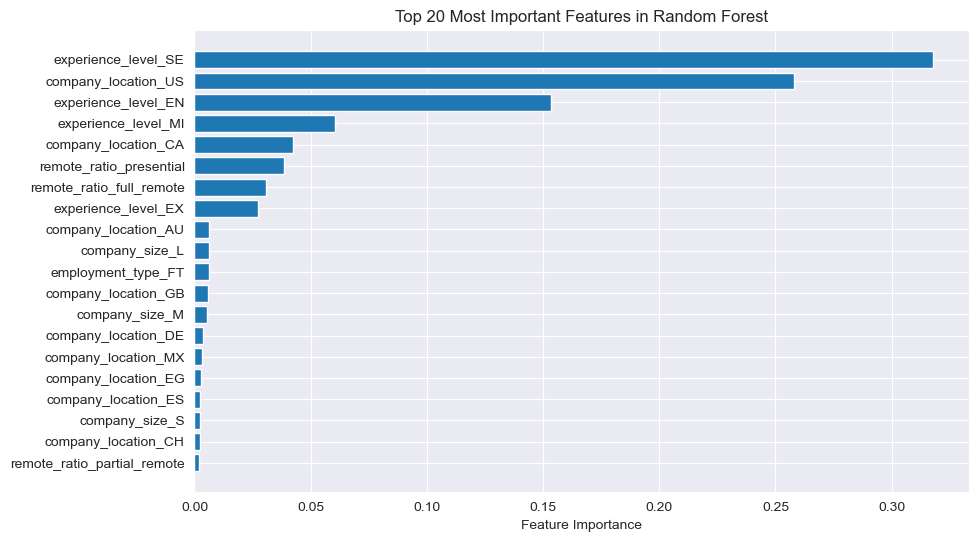

In [79]:
df_dum=pd.get_dummies(df[['salary_in_usd', 'experience_level', 'company_location', 'remote_ratio', 'company_size', 'employment_type']])

# Features and target
y = df_dum['salary_in_usd'] 
X = df_dum.drop('salary_in_usd', axis=1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# RandomForest with GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None]
}
rf_cv = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, 
                     scoring='neg_root_mean_squared_error', n_jobs=-1)
rf_cv.fit(X_train, y_train)

# Best model
best_rf = rf_cv.best_estimator_
print("Best parameters:", rf_cv.best_params_)

# Train RMSE (CV)
cv_scores = -cross_val_score(best_rf, X_train, y_train, cv=5, 
                             scoring='neg_root_mean_squared_error')
train_rmse = np.mean(cv_scores)

# Test RMSE
y_pred_test = best_rf.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Train RMSE (CV Mean): {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

# Feature importances (top 20)
importances = best_rf.feature_importances_
feature_names = np.array(X.columns)
top_idx = np.argsort(importances)[-20:]

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_idx)), importances[top_idx], align='center')
plt.yticks(range(len(top_idx)), feature_names[top_idx])
plt.xlabel("Feature Importance")
plt.title("Top 20 Most Important Features in Random Forest")
plt.show()

The remote_ratio and, company_size and employment type dont improve the metric (RMSE) used to evaluate the model.<br>
In terms of feature importances, remote ratio presential (and remote) is the most important value of the new features but its placed 6 (and 7)

Best parameters: {'max_depth': None, 'n_estimators': 100}
Train RMSE (CV Mean): 60901.4273
Test RMSE: 60650.8959


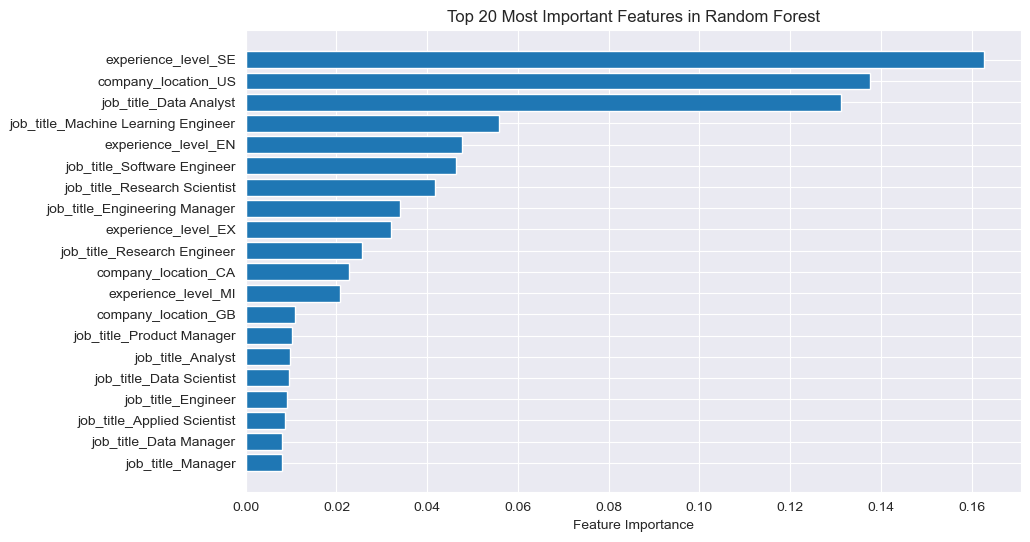

In [80]:
df_dum=pd.get_dummies(df[['salary_in_usd', 'experience_level', 'company_location', 'job_title']])

# Features and target
y = df_dum['salary_in_usd'] 
X = df_dum.drop('salary_in_usd', axis=1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# RandomForest with GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None]
}
rf_cv = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, 
                     scoring='neg_root_mean_squared_error', n_jobs=-1)
rf_cv.fit(X_train, y_train)

# Best model
best_rf = rf_cv.best_estimator_
print("Best parameters:", rf_cv.best_params_)

# Train RMSE (CV)
cv_scores = -cross_val_score(best_rf, X_train, y_train, cv=5, 
                             scoring='neg_root_mean_squared_error')
train_rmse = np.mean(cv_scores)

# Test RMSE
y_pred_test = best_rf.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Train RMSE (CV Mean): {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

# Feature importances (top 20)
importances = best_rf.feature_importances_
feature_names = np.array(X.columns)
top_idx = np.argsort(importances)[-20:]

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_idx)), importances[top_idx], align='center')
plt.yticks(range(len(top_idx)), feature_names[top_idx])
plt.xlabel("Feature Importance")
plt.title("Top 20 Most Important Features in Random Forest")
plt.show()

On the other hand, adding job_title as the 4th feature to the model ends up in a significant reduction of the RMSE of both training and test, and job title values are placed amongst the most important features to predict salaries.